# Setup Model

In [1]:
!pip install torch numpy scipy torchsummary datasets torchvision more-itertools matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

cwd = os.getcwd() 
sys.path.append(cwd+'/../')
from util import *
from torchvision import datasets, transforms
from torch.autograd import Variable
from itertools import chain

In [3]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        # self.prune = prune
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=(2,2))                                                                                                                          
        self.relu_conv1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=(2,2))
        self.relu_conv2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
          
        self.ip1 = nn.Linear(16*4*4, 256)
        self.relu_ip1 = nn.ReLU(inplace=True)
        self.ip2 = nn.Linear(256, 10)
        return
          
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu_conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu_conv2(x)
        x = self.pool2(x)
          
        x = x.view(x.size(0), 16*4*4)
          
        x = self.ip1(x)
        x = self.relu_ip1(x)
        x = self.ip2(x)
        return x

In [4]:
model = LeNet_5()
# print('Model: {}'.format(model))

In [5]:
path = 'saved_models/LeNet_5.origin.pth.tar'
pretrained_model = torch.load(path)
# print('Pretrained Mode: {}'.format(pretrained_model))

In [6]:
best_acc = pretrained_model['acc']
load_state(model, pretrained_model['state_dict'])
# print('best_acc: {}'.format(best_acc))
# print(model)

# Save weights

In [7]:
weights = []
org_layers = []
for m in model.children():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        weights.append(m.weight)
        org_layers.append(m)
# print('Weights: {}'.format(weights))
# print('layers: {}'.format(org_layers))

# Get the gradient of each weight

In [8]:
kwargs = {}

train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=128, shuffle=True, **kwargs)
criterion = nn.CrossEntropyLoss()

def getGrad(train_loader, model, criterion, weights):
    model.eval()
    grad_one = [torch.zeros(w.size()) for w in weights]
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = Variable(inputs), Variable(target)
        inputs.requires_grad_(True)
        output = model(inputs)
        loss = criterion(output, target)
        grad_params_1 = torch.autograd.grad(loss, weights)
        
        for j, gp in enumerate(grad_params_1):
            grad_one[j] += gp
            
    grad_one = [g / len(train_loader) for g in grad_one]
    return grad_one
        
grads = getGrad(train_loader, model, criterion, weights)
# print('Grad: {}'.format(grads))

# Calculate I for each weights

In [9]:
def getI(model, org_layers, grads):
    res = []
    for i in range(len(org_layers)):
        res.append(torch.pow(grads[i] * org_layers[i].weight, 2))
    return res

I = getI(model, org_layers, grads)
# print('I: {}'.format(I))
    

# Grouping

In [10]:
group_size = [1, 1, 1, 5]
def grouping(I, group = [1, 1, 1, 5]): # group size: one row
    I_groups = []
    for i in range(len(I)):
        layer = I[i]
        layer = layer.reshape(-1).data
        layer = np.add.reduceat(layer, np.arange(0, len(layer), group[3]))
        I_groups.append(layer)
    return I_groups
I_groups = grouping(I, group_size)
# print('I_groups: {}'.format(I_groups))

# Calculate the number of jobs for each layer

In [11]:
input_sizes = [[1,1,28,28], [1,8,14,14], [16*4*4, 256], [256, 10]]
output_sizes = []
def getJob(model, group_size, input_sizes):
    idx = 0
    jobs = []
    total_job = 0
    per_group_job = []
    for m in model.children():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if len(m.weight.shape) == 4:
                print(m.weight.shape)
                input_size = input_sizes[idx]
                kernel_size = m.weight.shape[2:]
                padding = m.padding
                stride = m.stride
                out_h = int((input_size[2] + 2 * padding[0] - kernel_size[0])/stride[0] + 1)
                out_w = int((input_size[3] + 2 * padding[1] - kernel_size[1])/stride[1] + 1)
                output_sizes.append([out_h, out_w])
                per_group_job.append(out_h * out_w)
                n_weights = np.prod(m.weight.shape)
                job = int(n_weights * out_h * out_w / np.prod(group_size))
                jobs.append(job)
                total_job += job
                idx += 1
            elif len(m.weight.shape) == 2:
                n_weights = np.prod(m.weight.shape)
                print(m.weight.shape)
                output_sizes.append([1, m.weight.shape[0]])
                job = int(n_weights / np.prod(group_size))
                jobs.append(job)
                per_group_job.append(1)
                total_job += job
                idx += 1
    return jobs, total_job, per_group_job

jobs, total_job, per_group_job = getJob(model, group_size, input_sizes)
print('jobs: {}'.format(jobs))
print('total job: {}'.format(total_job))
print('output size: {}'.format(output_sizes))
print('Per group jon: {}'.format(per_group_job))

torch.Size([8, 1, 5, 5])
torch.Size([16, 8, 5, 5])
torch.Size([256, 256])
torch.Size([10, 256])
jobs: [31360, 125440, 13107, 512]
total job: 170419
output size: [[28, 28], [14, 14], [1, 256], [1, 10]]
Per group jon: [784, 196, 1, 1]


# Sort based on the importance

In [12]:
metrics_sort = []
for i in range(len(I_groups)):
    layer = I_groups[i]
    metric_sort = sorted(range(len(layer)), key=lambda idx : layer[idx])
    metrics_sort.append(metric_sort)
# print('Metrics_sorted: {}'.format(metrics_sort))

# Calculate the importance for specific pruning ratios

In [41]:
acc_I = []
percentages = []
for i in range(len(metrics_sort)):
    acc = np.array(I_groups[i])[metrics_sort[i]]
    for j in range(len(acc) - 1):
        acc[j + 1] += acc[j]
    acc /= per_group_job[i]
#     sum = acc[-1]
#     acc /= sum
    percentage = np.linspace(0, 100, len(acc))
    percentages.append(percentage)
    print(acc[-1])
    acc_I.append(acc)
# print('acc: {}'.format(acc_I))

1.2654147e-06
9.384122e-06
0.00037070957
0.00039530778


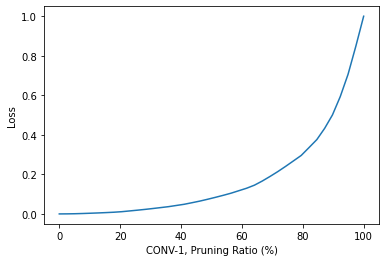

In [26]:
plt.xlabel('CONV-1, Pruning Ratio (%)')
plt.ylabel('Loss')
plt.plot(percentages[0], acc_I[0].data)

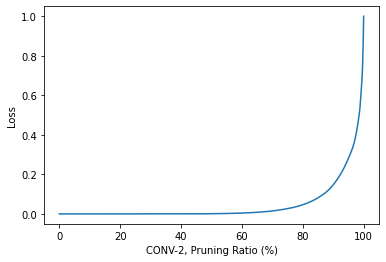

In [27]:
plt.xlabel('CONV-2, Pruning Ratio (%)')
plt.ylabel('Loss')
plt.plot(percentages[1], acc_I[1].data)

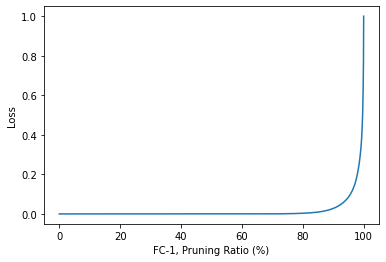

In [28]:
plt.xlabel('FC-1, Pruning Ratio (%)')
plt.ylabel('Loss')
plt.plot(percentages[2], acc_I[2].data)

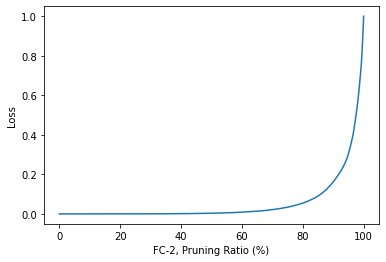

In [29]:
plt.xlabel('FC-2, Pruning Ratio (%)')
plt.ylabel('Loss')
plt.plot(percentages[3], acc_I[3].data)

# Calculate the pruning ratios for each layers via the importance

In [24]:
total_pruning_ratio = 0.6
def getPruningRatio(acc_I, total_pruning_ratio, total_job, jobs, per_group_job, threshold = 0):
    total_acc = list(chain.from_iterable(acc_I))
    total_acc.sort()
    PR = []
    indices = []
    remain_job = total_job
    ideal_job = int(total_job * (1 - total_pruning_ratio))
    for threshold in total_acc:
        PR = []
        indices = []
        for i in range(len(acc_I)):
            iters = iter(idx for idx, val in enumerate(acc_I[i]) if val > threshold)
            first_greater_than_idx = next(iters, -1)
            if first_greater_than_idx == -1:
                print('Layer {} is exhausted iteration'.format(i + 1))
                first_greater_than_idx = len(acc_I[i])
            PR.append(first_greater_than_idx / len(acc_I[i]) * 100)
            indices.append(first_greater_than_idx)
        remain_jobs = jobs - np.array(indices) * np.array(per_group_job)
        remain_job = 0
        for job in remain_jobs:
            remain_job += job
        if(remain_job <= ideal_job):
            break
#         print(threshold)
    print('Remain: {}'.format(remain_job))
    print('Ideal remain job: {}'.format(ideal_job))
    print('threshold: {}'.format(threshold))
    return PR, indices

for ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    print('============================================================================================')
    PR, indices = getPruningRatio(acc_I, ratio, total_job, jobs, per_group_job)
    print('Total Prun: {}'.format(ratio))
    print('Pruning Ratio: {}'.format(PR))
#     print('Indice'indices)

Remain: 142071
Ideal remain job: 153377
threshold: 0.0
Total Prun: 0.1
Pruning Ratio: [0.0, 19.53125, 29.356118400976506, 0.0]
Remain: 136216
Ideal remain job: 136335
threshold: 1.8741730022233718e-20
Total Prun: 0.2
Pruning Ratio: [0.0, 23.59375, 35.146475434848945, 0.0]
Remain: 119162
Ideal remain job: 119293
threshold: 1.5669369556221835e-13
Total Prun: 0.3
Pruning Ratio: [2.5, 35.9375, 41.119926762282574, 0.5859375]
Remain: 101527
Ideal remain job: 102251
threshold: 1.3949733729257119e-11
Total Prun: 0.4
Pruning Ratio: [20.0, 45.0, 46.978944156240466, 2.734375]
Remain: 85042
Ideal remain job: 85209
threshold: 7.241306165806094e-11
Total Prun: 0.5
Pruning Ratio: [40.0, 52.81249999999999, 50.099176075678976, 3.515625]
Remain: 68065
Ideal remain job: 68167
threshold: 2.1710566677768384e-10
Total Prun: 0.6
Pruning Ratio: [62.5, 60.46875000000001, 52.47940189197436, 4.4921875]
Remain: 50502
Ideal remain job: 51125
threshold: 6.069093005933723e-10
Total Prun: 0.7
Pruning Ratio: [85.0, 68

Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 

Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 

Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 

Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 is exhausted iteration
Layer 1 

In [39]:
def getPruningRatio2(acc_I, loss_rate, per_group_job, total_job, jobs):
    PR = []
    indices = []
    remain_job = total_job
    for i in range(len(acc_I)):
        iters = iter(idx for idx, val in enumerate(acc_I[i]) if val > loss_rate)
        first_greater_than_idx = next(iters, -1)
        if first_greater_than_idx == -1:
            print('Layer {} is exhausted iteration'.format(i + 1))
            first_greater_than_idx = len(acc_I[i])
        PR.append(first_greater_than_idx / len(acc_I[i]) * 100)
        indices.append(first_greater_than_idx)
    remain_jobs = jobs - np.array(indices) * np.array(per_group_job)
    remain_job = 0
    for job in remain_jobs:
        remain_job += job
    print('Remain: {}'.format(remain_job))
    return PR, indices

for loss_rate in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print('============================================================================================')
    PR, indices = getPruningRatio2(acc_I, loss_rate, per_group_job, total_job, jobs)
#     print('Total Prun: {}'.format(ratio))
    print('Pruning Ratio: {}'.format(PR))
#     print('Indice'indices)

Remain: 31414
Pruning Ratio: [55.00000000000001, 86.71875, 95.6438815990235, 85.9375]
Remain: 19326
Pruning Ratio: [70.0, 92.34375, 97.91730241074154, 91.796875]
Remain: 12127
Pruning Ratio: [80.0, 95.46875, 98.88617638083613, 94.921875]
Remain: 8133
Pruning Ratio: [85.0, 97.34375, 99.38968568812938, 96.484375]
Remain: 5938
Pruning Ratio: [87.5, 98.4375, 99.64906927067439, 97.4609375]
